In [1]:
import gpflow as gpf
import numpy as np
import matplotlib.pyplot as plt

from model_trainers.shared_independent_trainer import SharedIndependentTrainer
from model_trainers.separate_independent_trainer import SeparateIndependentTrainer
from model_trainers.coreg_trainer import CoregTrainer

In [2]:
def f_1_hf(x, a):
    return np.sin(2 * np.pi * x)

def f_1_lf(x, a):
    return (x / 4 - np.sqrt(2)) * np.sin(2 * np.pi * x + a * np.pi) ** a

def f_2_hf(x, a):
    return np.cos(2 * np.pi * x)

def f_2_lf(x, a):
    return (x / 4 - np.sqrt(2)) * np.cos(2 * np.pi * x + a * np.pi) ** a

In [3]:
def generate_data(Ns, fs_2d, a):
    Xs = []
    Ys = []
    for N, fs in zip(Ns, fs_2d):
        X = np.random.rand(N)[:, None]
        Xs.append(X)
        Ys.append(np.hstack([f(X, a) for f in fs]))
    return Xs, Ys

In [4]:
def plot_model(trainer, data, fidelity, lower=-0, upper=1):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = trainer.predict(pX, fidelity=fidelity)
    plt.plot(data[0], data[1], "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX[:, 0], pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {trainer.get_elbo(training=True):.3}")

# Single Fidelity Model

In [5]:
Ns = [10]  # List of number of data points to use per fidelity
fs_2d = [[f_1_hf, f_2_hf]]  # List of outputs per fidelity. Should be a 2D list
D = 1  # number of input dimensions
M = 5  # number of inducing points
O = 2  # number of outputs
max_fidelity = 1  # maximum fidelity
a = 4  # parameter for function evals

In [6]:
Xs, Ys = generate_data(Ns, fs_2d, a)

coreg_trainer = CoregTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
coreg_trainer.construct_model()

In [7]:
coreg_trainer.train()

Start training...


  0%|          | 0/1 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


100%|██████████| 1/1 [02:31<00:00, 151.48s/it]


Done training! Final ELBO (higher is better): 46.7


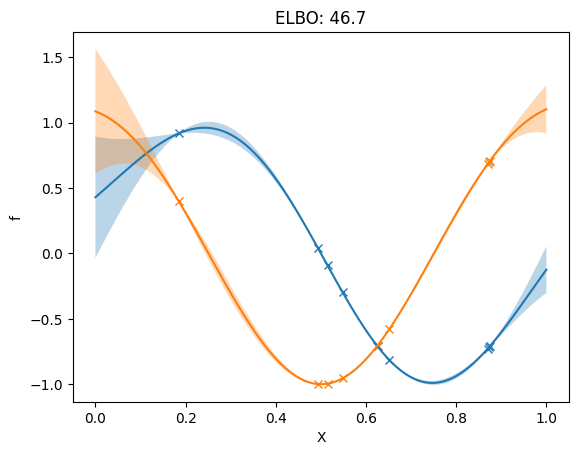

In [8]:
plot_model(coreg_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [9]:
coreg_trainer.checkpoints[0].checkpoints

['Coregion_0\\ckpt-3017', 'Coregion_0\\ckpt-3018', 'Coregion_0\\ckpt-3019']

In [81]:
shared_trainer = SharedIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
shared_trainer.construct_model()

In [82]:
shared_trainer.train()

Start training...


100%|██████████| 1/1 [00:10<00:00, 10.37s/it]

Done training! Final ELBO (higher is better): 21.6


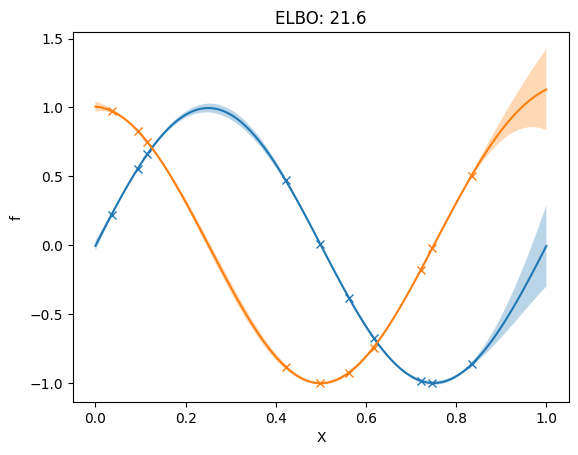

In [83]:
plot_model(shared_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [84]:
sep_trainer = SeparateIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
sep_trainer.construct_model()

In [85]:
sep_trainer.train()

Start training...


100%|██████████| 1/1 [00:16<00:00, 16.92s/it]


Done training! Final ELBO (higher is better): 21.6


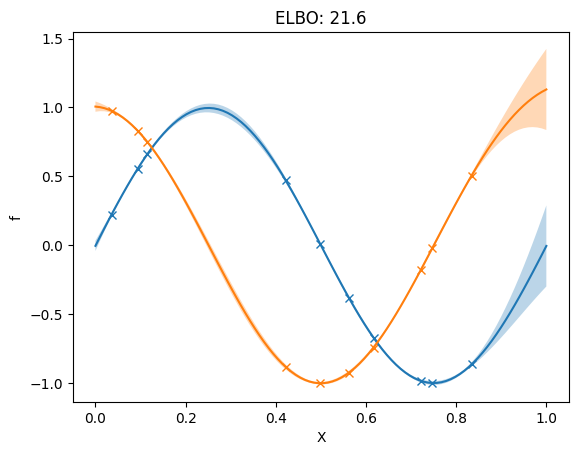

In [86]:
plot_model(sep_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

# 2 Fidelity Model

In [89]:
Ns = [100, 10]  # List of number of data points to use per fidelity
fs_2d = [[f_1_lf, f_2_lf], [f_1_hf, f_2_hf]]  # List of outputs per fidelity. Should be a 2D list
D = 1  # number of input dimensions
M = 5  # number of inducing points
O = 2  # number of outputs
max_fidelity = 2  # maximum fidelity
a = 4  # parameter for function evals

In [90]:
Xs, Ys = generate_data(Ns, fs_2d, a)

coreg_trainer = CoregTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
coreg_trainer.construct_model()

Start training...


100%|██████████| 2/2 [00:16<00:00,  8.03s/it]


Done training! Final ELBO (higher is better): -21.4


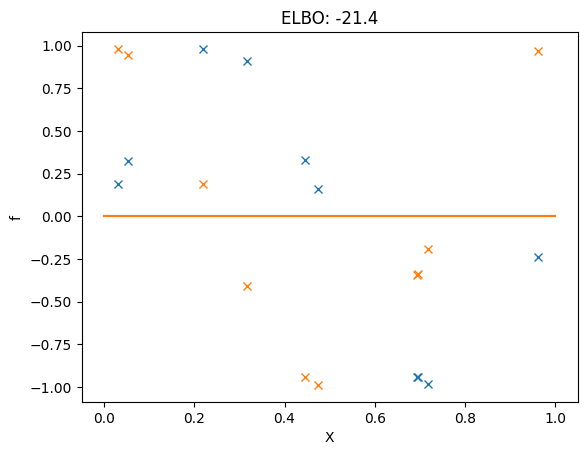

In [91]:
coreg_trainer.train()
plot_model(coreg_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [92]:
shared_trainer = SharedIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
shared_trainer.construct_model()

Start training...


100%|██████████| 2/2 [00:17<00:00,  8.74s/it]


Done training! Final ELBO (higher is better): 20.3


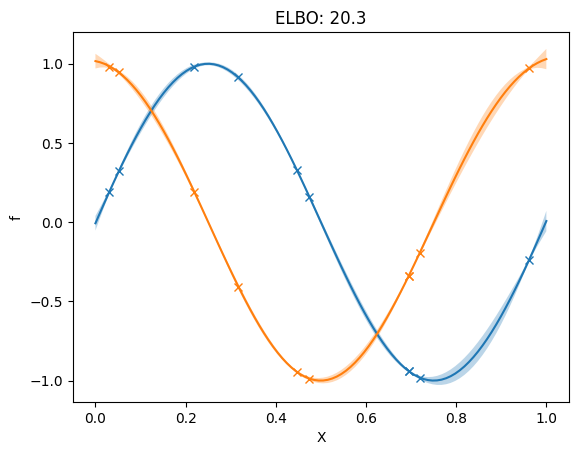

In [93]:
shared_trainer.train()
plot_model(shared_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [94]:
sep_trainer = SeparateIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
sep_trainer.construct_model()

In [95]:
sep_trainer.train()

Start training...


100%|██████████| 2/2 [00:41<00:00, 20.90s/it]


Done training! Final ELBO (higher is better): 20.3


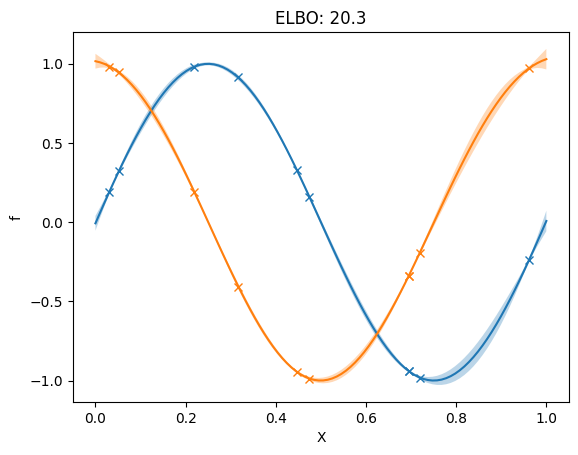

In [96]:
plot_model(sep_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

# 6 Fidelity Model

In [97]:
Ns = [300, 200, 100, 50, 30, 10]  # List of number of data points to use per fidelity
fs_2d = [[f_1_lf, f_2_lf], [f_1_lf, f_2_lf], [f_1_lf, f_2_lf], [f_1_lf, f_2_lf], [f_1_lf, f_2_lf], [f_1_hf, f_2_hf]]  # List of outputs per fidelity. Should be a 2D list
D = 1  # number of input dimensions
M = 5  # number of inducing points
O = 2  # number of outputs
max_fidelity = 2  # maximum fidelity
a = 4  # parameter for function evals

In [98]:
Xs, Ys = generate_data(Ns, fs_2d, a)

coreg_trainer = CoregTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
coreg_trainer.construct_model()

In [99]:
coreg_trainer.train()

Start training...


100%|██████████| 6/6 [01:02<00:00, 10.43s/it]


Done training! Final ELBO (higher is better): -17.9


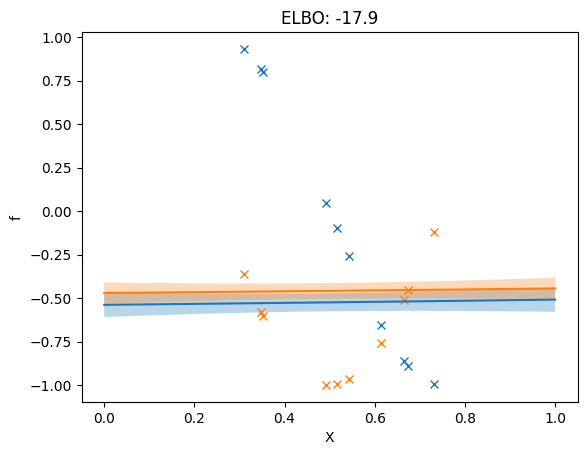

In [100]:
plot_model(coreg_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [101]:
shared_trainer = SharedIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
shared_trainer.construct_model()

In [102]:
shared_trainer.train()

Start training...


100%|██████████| 6/6 [00:43<00:00,  7.24s/it]

Done training! Final ELBO (higher is better): 41.3


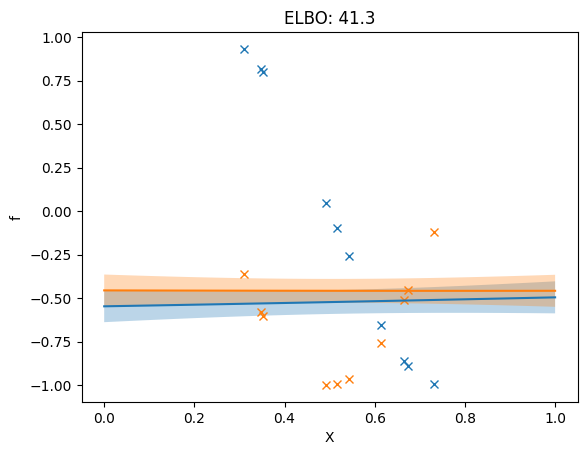

In [103]:
plot_model(shared_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)

In [104]:
sep_trainer = SeparateIndependentTrainer(
    Xs=Xs,
    Ys=Ys,
    inducing_size=M,
    optimizer=gpf.optimizers.Scipy()
)
sep_trainer.construct_model()

In [105]:
sep_trainer.train()

Start training...


100%|██████████| 6/6 [01:31<00:00, 15.26s/it]


Done training! Final ELBO (higher is better): 41.5


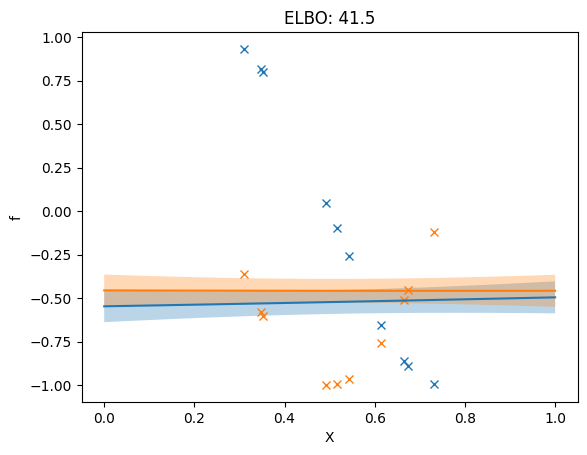

In [106]:
plot_model(sep_trainer, (Xs[-1], Ys[-1]), max_fidelity, lower=0, upper=1)